In [25]:
using Pkg; Pkg.activate("."); 
using StatsBase
using Revise
import MUST
using PyPlot
using Interpolations
using PyCall
using KernelDensity

#MUST.@import_dispatch "../../../dispatch2_clean/dispatch2" 
MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2"

MUST.@get_help visual
pl = pyimport("matplotlib.pylab");

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/solar_model/Project.toml`


In [26]:
# The gas pressure is not saved in dispatch, so we use the same EOS for both to get it
# eos_path = "input_data/solar_lte"
eos_path = "input_data/TSO_table_lines1_8bins"
sqEOS = MUST.SquareGasEOS(MUST.@in_dispatch(eos_path));

In [27]:
ext = "TSO"

"TSO"

In [28]:
folder_stagger = "/ptmp/peitner/model_grid/MUST.jl/examples/stagger2bifrost"
stagger        = MUST.Box("box_solar_stagger", folder=folder_stagger);

In [32]:
folder_model     = MUST.@in_dispatch "data/sun_TSO_select"
model, model_t   = MUST.Boxes(folder_model, snaps=[58])
models, models_t = MUST.Boxes(folder_model, snaps=[58]);

In [35]:
function get_pg!(model, eos)
    e_cube_model = MUST.bisect_energy(eos, size(model[:d]); d=model[:d], T=model[:T])
            
    pg = MUST.lookup(eos, :Pg, model[:d], e_cube_model)
    MUST.add!(model, pg, :Pg);
end

get_pg! (generic function with 1 method)

In [36]:
get_pg!(model, sqEOS)

# Surface Density Slice

In [37]:
optical_surface = MUST.height_where(; τ_ross=1.0)                  # function that interpolates height where lgtau=0
surf_model      = MUST.reduce_by_column(optical_surface, model);   # Reduce data cube to plane by interp. in height according to optical surface 
surf_stagger    = MUST.reduce_by_column(optical_surface, stagger); # Reduce data cube to plane by interp. in height according to optical surface 

In [38]:
# Align the z axis such that the point is at this average depth
model.z   = model.z .- MUST.plane_statistic(mean, surf_model, :z)
stagger.z = stagger.z .- MUST.plane_statistic(mean, surf_stagger, :z);

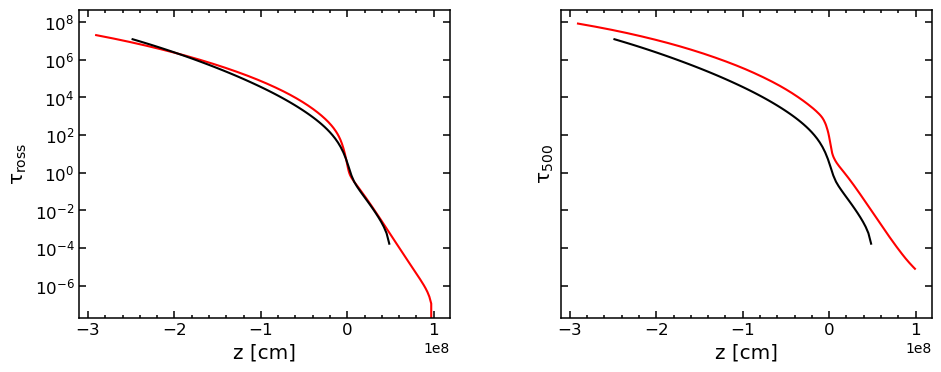

In [39]:
d_model   = MUST.plane_statistic(mean, model, :τ_ross) 
d_stagger = MUST.plane_statistic(mean, stagger, :τ_ross) 
d2_stagger = MUST.plane_statistic(mean, stagger, :τ) 

f, ax = plt.subplots(1, 2, figsize=(11,4), sharey=true)
basic_plot!.(ax)

plt.subplots_adjust(wspace=0.3)

z_stagger = MUST.axis(stagger, :z)
z_model   = MUST.axis(model, :z)

ax[1].semilogy(z_stagger, d_stagger, color="red")
ax[1].semilogy(z_model, d_model, color="k");
ax[2].semilogy(z_stagger, d2_stagger, color="red")
ax[2].semilogy(z_model, d_model, color="k");

ax[1].set_xlabel("z [cm]", fontsize="x-large")
ax[2].set_xlabel("z [cm]", fontsize="x-large")

ax[1].set_ylabel(L"\rm \tau_{ross}", fontsize="x-large")
ax[2].set_ylabel(L"\rm \tau_{500}", fontsize="x-large");

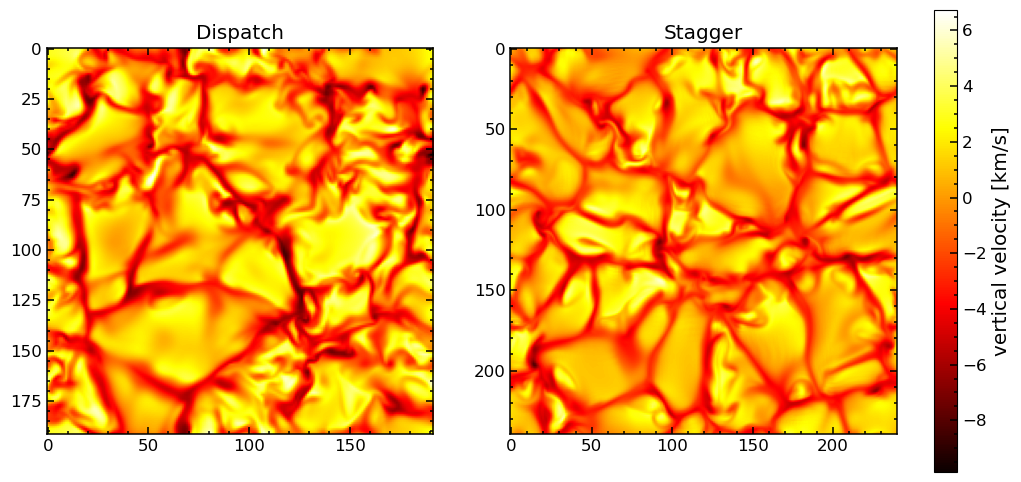

In [40]:
d_model   = MUST.axis(surf_model, :uz) ./ 1e5
d_stagger = MUST.axis(surf_stagger, :uz) ./ 1e5

f, ax = plt.subplots(1, 2, figsize=(12,6))
basic_plot!.(ax)

margins_model   = minimum(d_model), maximum(d_model)
margins_stagger = minimum(d_stagger), maximum(d_stagger)
vmin = min(margins_model[1], margins_stagger[1])
vmax = max(margins_model[2], margins_stagger[2])

im1 = ax[1].imshow(d_model, vmin=vmin, vmax=vmax, cmap="hot")
im2 = ax[2].imshow(d_stagger, vmin=vmin, vmax=vmax, cmap="hot")

cbar = add_cbar(im1, ax)
cbar.set_label("vertical velocity [km/s]", fontsize="x-large")

ax[1].set_title("Dispatch", fontsize="x-large")
ax[2].set_title("Stagger", fontsize="x-large")

f.savefig("disp_stag_surf_$(ext).pdf", bbox_inches="tight");

# Vertical velocity

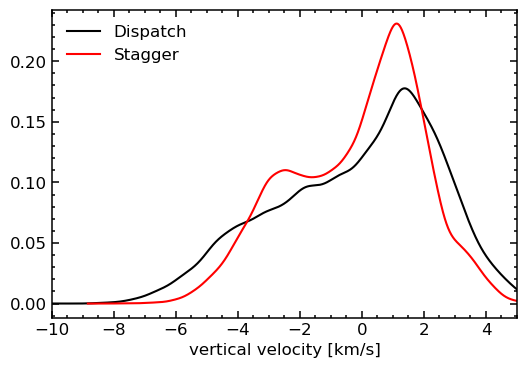

In [41]:
d_model   = kde(reshape(MUST.axis(surf_model, :uz), :) ./ 1e5)
d_stagger = kde(reshape(MUST.axis(surf_stagger, :uz), :) ./ 1e5)

f, ax = plt.subplots(1, 1, figsize=(6,4))
basic_plot!(ax)

ax.plot(d_model.x, d_model.density, color="k", label="Dispatch")
ax.plot(d_stagger.x, d_stagger.density, color="r", label="Stagger")

ax.set_xlim(-10,5)
ax.set_xlabel("vertical velocity [km/s]", fontsize="large")
ax.legend(framealpha=0, loc="upper left", fontsize="large")

f.savefig("disp_stag_uz_distr_$(ext).pdf", bbox_inches="tight");

# Temperature profiles

In [14]:
# get the std-dev of 20 snapshots (this only can be done for the dispatch)
std_t_model = zeros(length(MUST.axis(model, :z)), length(models))
for i in eachindex(models)
    std_t_model[:, i] .= MUST.plane_statistic(mean, models[i], :T)
end

std_model = reshape(std(std_t_model, dims=2), :);

LoadError: ArgumentError: invalid index: :T of type Symbol

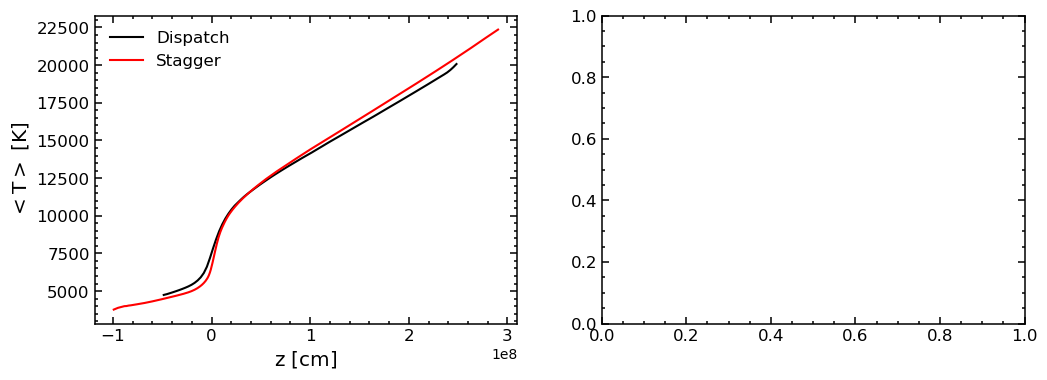

In [42]:
d_model   = MUST.plane_statistic(mean, model, :T)
d_stagger = MUST.plane_statistic(mean, stagger, :T)

z_model   = MUST.axis(model, :z)
z_stagger = MUST.axis(stagger, :z)

f, ax = plt.subplots(1, 2, figsize=(12,4))
basic_plot!.(ax)

ax[1].plot(-z_model, d_model, color="k", label="Dispatch")
ax[1].plot(-z_stagger, d_stagger, color="r", label="Stagger")
ax[1].set_ylabel(L"\rm <T> \ [K]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper left", fontsize="large")

#ax[2].plot(-z_model, std_model, color="k", label="Dispatch")
#ax[2].set_ylabel(L"\rm \sigma_T \ [K]", fontsize="x-large")
#ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

f.savefig("disp_stag_t_sT_geo_$(ext).pdf", bbox_inches="tight");

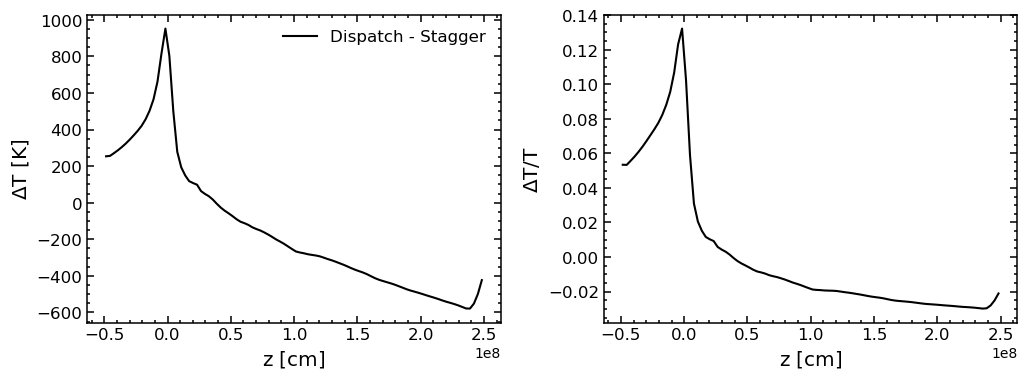

In [43]:
d_model   = MUST.plane_statistic(mean, model, :T)
d_stagger = MUST.plane_statistic(mean, stagger, :T)

z_model   = MUST.axis(model, :z)
z_stagger = MUST.axis(stagger, :z)

# interpolate stagger on dispatch scale
d_ip_stagger = LinearInterpolation(z_stagger, d_stagger)(z_model)

f, ax = plt.subplots(1, 2, figsize=(12,4))
basic_plot!.(ax)
plt.subplots_adjust(wspace=0.25)

ax[1].plot(-z_model, d_model .- d_ip_stagger, color="k", label="Dispatch - Stagger")

ax[1].set_ylabel(L"\rm \Delta T\ [K]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper right", fontsize="large")

ax[2].plot(-z_model, (d_model .- d_ip_stagger) ./ d_model, color="k", label="Dispatch - Stagger")
ax[2].set_ylabel(L"\rm \Delta T / T", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

f.savefig("disp_stag_dt_dTT_geo_$(ext).pdf", bbox_inches="tight");

# Density

In [121]:
# get the std-dev of 20 snapshots (this only can be done for the dispatch)
std_t_model = zeros(length(MUST.axis(model, :z)), length(models))
for i in eachindex(models)
    std_t_model[:, i] .= MUST.plane_statistic(mean, models[i], :d)
end

std_model = reshape(std(std_t_model, dims=2), :);

In [122]:
z0 = MUST.closest(MUST.axis(stagger, :z), 0.0)
d_ini_stagger = mean(stagger[:d][:,:,z0])

2.4019752f-7

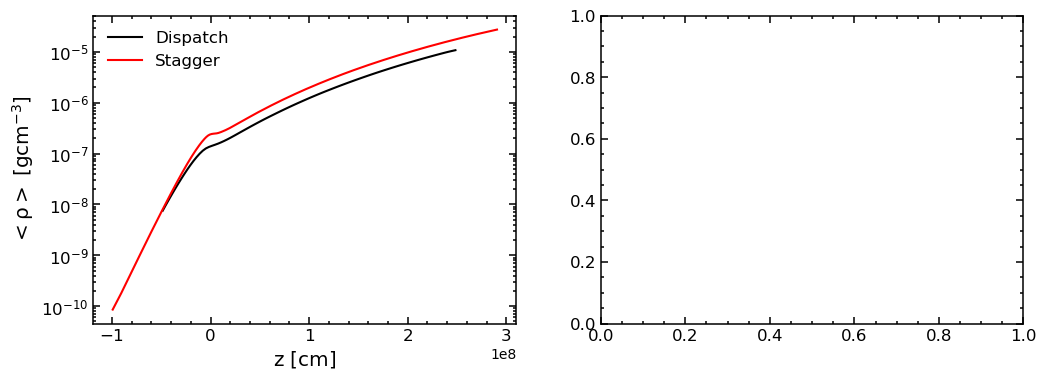

In [45]:
d_model   = MUST.plane_statistic(mean, model, :d)
d_stagger = MUST.plane_statistic(mean, stagger, :d)

z_model   = MUST.axis(model, :z)
z_stagger = MUST.axis(stagger, :z)

f, ax = plt.subplots(1, 2, figsize=(12,4))
basic_plot!.(ax)

ax[1].semilogy(-z_model, d_model, color="k", label="Dispatch")
ax[1].semilogy(-z_stagger, d_stagger, color="r", label="Stagger")
ax[1].set_ylabel(L"\rm <\rho> \ [g cm^{-3}]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper left", fontsize="large")

#ax[2].semilogy(-z_model, std_model ./ d_model , color="k", label="Dispatch")
#ax[2].set_ylabel(L"\rm \sigma_{\rho} / \rho\ [g cm^{-3}]", fontsize="x-large")
#ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

f.savefig("disp_stag_Rho_sRho_geo_$(ext).pdf", bbox_inches="tight");

# Pressure

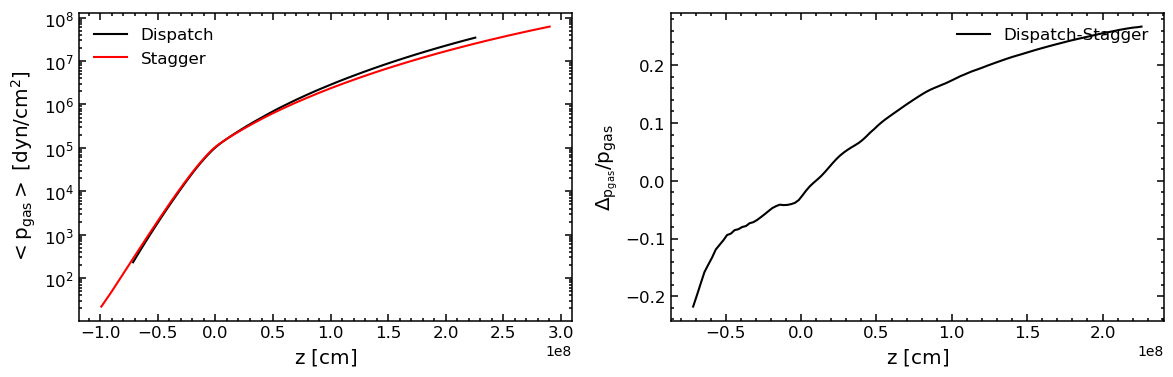

In [124]:
d_model     = MUST.plane_statistic(mean, model, :Pg)
d_stagger   =  MUST.plane_statistic(mean, stagger, :Pg)

z_model   = MUST.axis(model, :z)
z_stagger = MUST.axis(stagger, :z)

d_ip_stagger = LinearInterpolation(z_stagger, d_stagger)(z_model)

f, ax = plt.subplots(1, 2, figsize=(14,4))
basic_plot!.(ax)

ax[1].semilogy(-z_model, d_model, color="k", label="Dispatch")
ax[1].semilogy(-z_stagger, d_stagger, color="r", label="Stagger")
ax[1].set_ylabel(L"\rm <p_{gas}> \ [dyn/cm^2]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper left", fontsize="large")

ax[2].plot(-z_model, (d_model .- d_ip_stagger) ./ d_model, color="k", label="Dispatch-Stagger")
ax[2].set_ylabel(L"\rm \Delta_{p_{gas}} / p_{gas}", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[2].legend(framealpha=0, loc="upper right", fontsize="large")

f.savefig("disp_stag_pg_dpgpg_geo_$(ext).pdf", bbox_inches="tight");

In [125]:
pturb = model[:d] .* model[:uz].^2
MUST.add!(model, pturb, :pturb)

pturb = stagger[:d] .* stagger[:uz].^2
MUST.add!(stagger, pturb, :pturb)

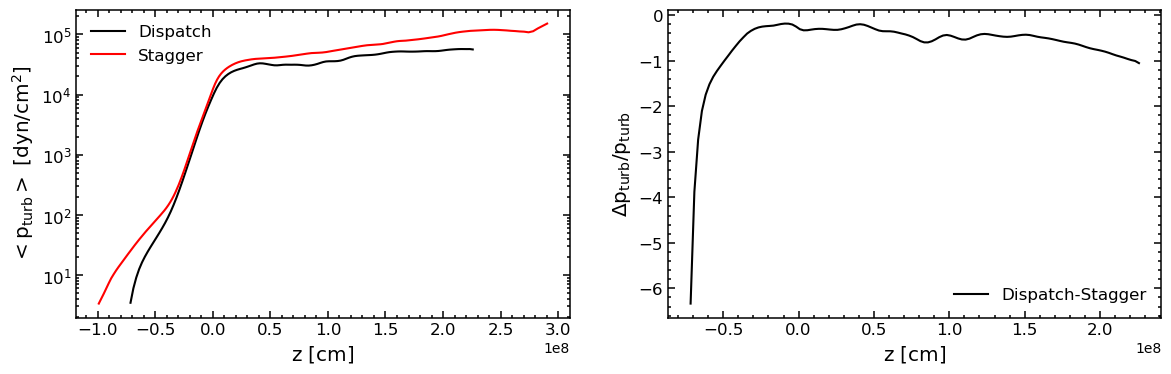

In [126]:
d_model     = MUST.plane_statistic(mean, model, :pturb)
std_model   = MUST.plane_statistic(std, model, :pturb)
d_stagger   =  MUST.plane_statistic(mean, stagger, :pturb)
std_stagger =  MUST.plane_statistic(std, stagger, :pturb)

z_model   = MUST.axis(model, :z)
z_stagger = MUST.axis(stagger, :z)

d_ip_stagger = LinearInterpolation(z_stagger, d_stagger)(z_model)

f, ax = plt.subplots(1, 2, figsize=(14,4))
basic_plot!.(ax)

ax[1].semilogy(-z_model, d_model, color="k", label="Dispatch")
ax[1].semilogy(-z_stagger, d_stagger, color="r", label="Stagger")
ax[1].set_ylabel(L"\rm <p_{turb}> \ [dyn/cm^2]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper left", fontsize="large")

ax[2].plot(-z_model, (d_model .- d_ip_stagger) ./ d_model, color="k", label="Dispatch-Stagger")
ax[2].set_ylabel(L"\rm \Delta p_{turb} / p_{turb}", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[2].legend(framealpha=0, loc="lower right", fontsize="large")

f.savefig("disp_stag_pt_dpt_geo_$(ext).pdf", bbox_inches="tight");

In [127]:
ratio = model[:pturb] ./ model[:pg]
MUST.add!(model, ratio, :pturb_pgas)

ratio = stagger[:pturb] ./ stagger[:Pg]
MUST.add!(stagger, ratio, :pturb_pgas);

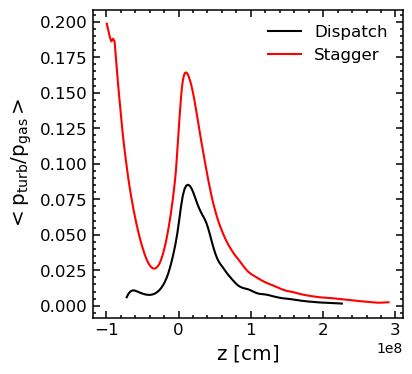

In [128]:
gas_model     = MUST.plane_statistic(mean, model, :pturb_pgas)
gas_stagger   =  MUST.plane_statistic(mean, stagger, :pturb_pgas)

z_model   = MUST.axis(model, :z)
z_stagger = MUST.axis(stagger, :z)

f, ax = plt.subplots(1, 1, figsize=(4,4))
basic_plot!.(ax)

ax.plot(-z_model, gas_model, color="k", label="Dispatch")
ax.plot(-z_stagger, gas_stagger, color="r", label="Stagger")
ax.set_ylabel(L"\rm <p_{turb} / p_{gas}> \ ", fontsize="x-large")
ax.set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax.legend(framealpha=0, loc="upper right", fontsize="large")

f.savefig("disp_stag_pgpt_geo_$(ext).pdf", bbox_inches="tight");

# Root mean square

In [129]:
rms_fluctuation(x) = √(mean(x.^2) -  mean(x) .^2)
rms(x) = √(mean(x.^2));

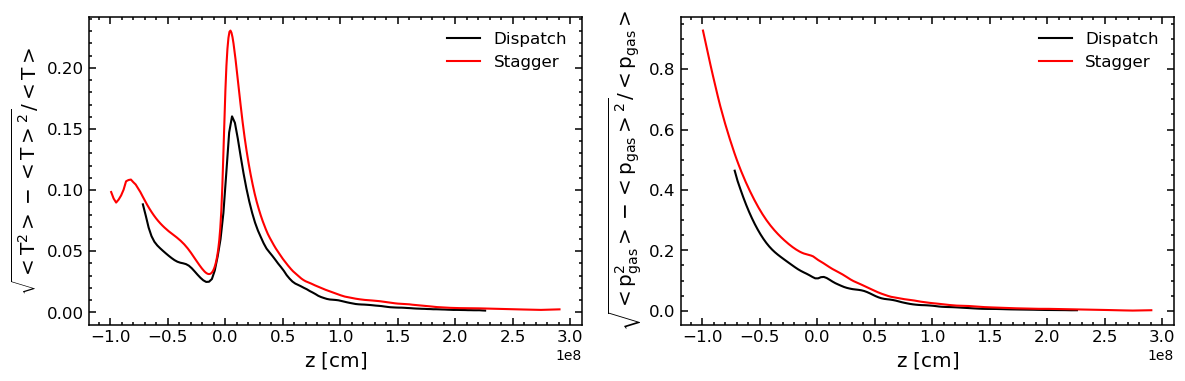

In [130]:
d_model     = MUST.plane_statistic(rms_fluctuation, model, :T)
d_stagger   = MUST.plane_statistic(rms_fluctuation, stagger, :T)
md_model    = MUST.plane_statistic(mean, model, :T)
md_stagger  = MUST.plane_statistic(mean, stagger, :T)
p_model     = MUST.plane_statistic(rms_fluctuation, model, :pg)
p_stagger   = MUST.plane_statistic(rms_fluctuation, stagger, :Pg)
mp_model    = MUST.plane_statistic(mean, model, :pg)
mp_stagger  = MUST.plane_statistic(mean, stagger, :Pg)

z_model   = MUST.axis(model, :z)
z_stagger = MUST.axis(stagger, :z)

f, ax = plt.subplots(1, 2, figsize=(14,4))
basic_plot!.(ax)

ax[1].plot(-z_model, d_model ./ md_model, color="k", label="Dispatch")
ax[1].plot(-z_stagger, d_stagger ./ md_stagger, color="r", label="Stagger")
ax[1].set_ylabel(L"\rm \sqrt{<T^2> - <T>^2} / <T>", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper right", fontsize="large")

ax[2].plot(-z_model, p_model ./ mp_model, color="k", label="Dispatch")
ax[2].plot(-z_stagger, p_stagger ./ mp_stagger, color="r", label="Stagger")
ax[2].set_ylabel(L"\rm \sqrt{<p_{gas}^2> - <p_{gas}>^2} / <p_{gas}>", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[2].legend(framealpha=0, loc="upper right", fontsize="large")

f.savefig("disp_stag_rmsT_rmsP_geo_$(ext).pdf", bbox_inches="tight");

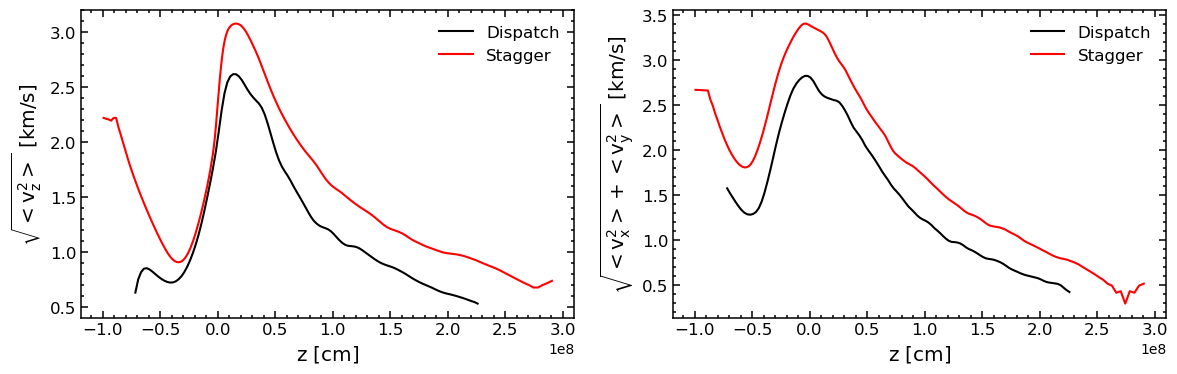

In [131]:
d_model     = MUST.plane_statistic(rms, model, :uz) ./ 1e5
d_stagger   = MUST.plane_statistic(rms, stagger, :uz) ./ 1e5

x_model     = MUST.plane_statistic(rms, model, :ux) .^2
x_stagger   = MUST.plane_statistic(rms, stagger, :ux) .^2
y_model     = MUST.plane_statistic(rms, model, :uy) .^2
y_stagger   = MUST.plane_statistic(rms, stagger, :uy) .^2

s_model = .√(x_model .+ y_model) ./ 1e5
s_stagger = .√(x_stagger .+ y_stagger) ./ 1e5

z_model   = MUST.axis(model, :z)
z_stagger = MUST.axis(stagger, :z)

f, ax = plt.subplots(1, 2, figsize=(14,4))
basic_plot!.(ax)

ax[1].plot(-z_model, d_model, color="k", label="Dispatch")
ax[1].plot(-z_stagger, d_stagger, color="r", label="Stagger")
ax[1].set_ylabel(L"\rm \sqrt{<v_z^2>} \ [km/s]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper right", fontsize="large")

ax[2].plot(-z_model, s_model, color="k", label="Dispatch")
ax[2].plot(-z_stagger, s_stagger, color="r", label="Stagger")
ax[2].set_ylabel(L"\rm \sqrt{<v_x^2> + <v_y^2>} \ [km/s]", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[2].legend(framealpha=0, loc="upper right", fontsize="large")

f.savefig("disp_stag_rmsUz_rmsUxUy_geo_$(ext).pdf", bbox_inches="tight");

# Iso-$\tau$ surfaces
We can inteprolate the cubes to a new height scale

In [132]:
model_τ   = MUST.height_scale(model, :τ_ross, Float32[10^(5), 10^(-5.0)])
stagger_τ = MUST.height_scale(stagger, :τ_ross, Float32[10^(5), 10^(-5.0)]);

In [133]:
MUST.save(model_τ, name="box_model_sun")
MUST.save(stagger_τ, name="box_stagger_sun");

In [134]:
#model_τ   = MUST.Box("box_model_sun")
#stagger_τ = MUST.Box("box_stagger_sun");

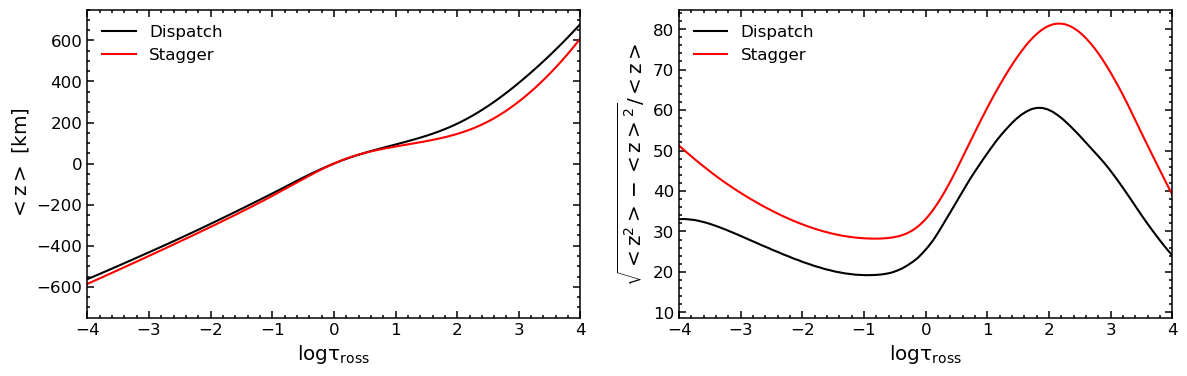

In [135]:
d_model   = MUST.plane_statistic(mean, model_τ, :z) 
d_stagger = MUST.plane_statistic(mean, stagger_τ, :z) 

s_model   = MUST.plane_statistic(rms_fluctuation, model_τ, :z) 
s_stagger = MUST.plane_statistic(rms_fluctuation, stagger_τ, :z) 

z_model   = log.(10, MUST.axis(model_τ, :τ_ross, 3))
z_stagger = log.(10, MUST.axis(stagger_τ, :τ_ross, 3))

f, ax = plt.subplots(1, 2, figsize=(14,4))
basic_plot!.(ax)

ax[1].set_xlim(-4, 4)
ax[1].set_ylim(-750, 750)
ax[2].set_xlim(-4, 4)

ax[1].plot(z_model, -d_model ./ 1e5, color="k", label="Dispatch")
ax[1].plot(z_stagger, -d_stagger ./ 1e5, color="r", label="Stagger")
ax[1].set_ylabel(L"\rm <z>\ [km]", fontsize="x-large")
ax[1].set_xlabel(L"\rm log \tau_{ross} ", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper left", fontsize="large");

ax[2].plot(z_model, s_model ./ 1e5, color="k", label="Dispatch")
ax[2].plot(z_stagger, s_stagger ./ 1e5, color="r", label="Stagger")
ax[2].set_ylabel(L"\rm \sqrt{<z^2> - <z>^2} / <z>", fontsize="x-large")
ax[2].set_xlabel(L"\rm log \tau_{ross} ", fontsize="x-large")
ax[2].legend(framealpha=0, loc="upper left", fontsize="large")

f.savefig("disp_stag_z_rmsz_tauross_$(ext).pdf", bbox_inches="tight");

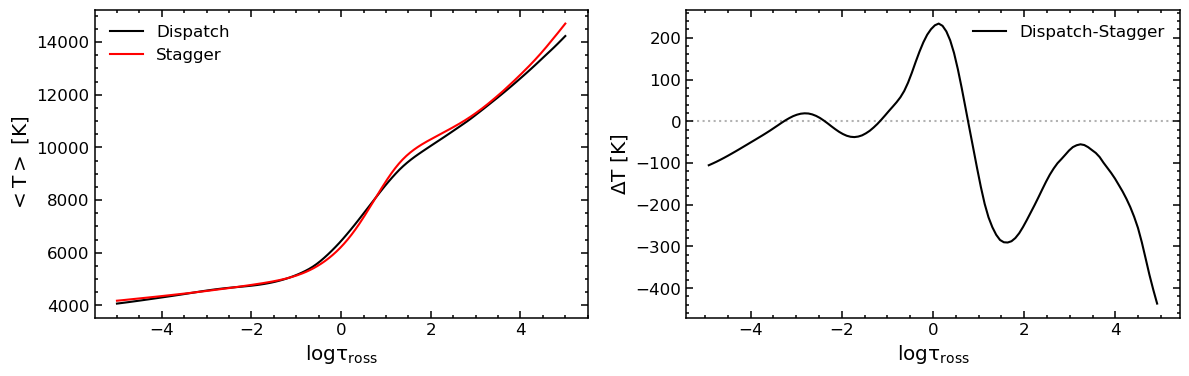

In [136]:
d_model   = MUST.plane_statistic(mean, model_τ, :T) 
d_stagger = MUST.plane_statistic(mean, stagger_τ, :T) 

z_model   = log.(10, MUST.axis(model_τ, :τ_ross, 3))
z_stagger = log.(10, MUST.axis(stagger_τ, :τ_ross, 3))

f, ax = plt.subplots(1, 2, figsize=(14,4))
basic_plot!.(ax)

mask = MUST.uniqueidx(z_stagger)
masks = sortperm(z_stagger[mask])
d_ip_stagger = LinearInterpolation(z_stagger[mask][masks], d_stagger[mask][masks])(z_model[2:end-1])

#ax[1].set_xlim(-4, 1)
#ax[2].set_xlim(-4, 1)
#ax[1].set_ylim(4000, 9000)
#ax[2].set_ylim(-300, 300)
ax[2].axhline(0, color="k", alpha=0.3, ls=":")

ax[1].plot(z_model, d_model, color="k", label="Dispatch")
ax[1].plot(z_stagger, d_stagger, color="r", label="Stagger")
ax[1].set_ylabel(L"\rm <T>\ [K]", fontsize="x-large")
ax[1].set_xlabel(L"\rm log \tau_{ross} ", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper left", fontsize="large");

ax[2].plot(z_model[2:end-1], d_model[2:end-1] .- d_ip_stagger, color="k", label="Dispatch-Stagger")
ax[2].set_ylabel(L"\rm \Delta T \ [K]", fontsize="x-large")
ax[2].set_xlabel(L"\rm log \tau_{ross} ", fontsize="x-large")
ax[2].legend(framealpha=0, loc="upper right", fontsize="large")

f.savefig("disp_stag_t_dt_tauross_$(ext).pdf", bbox_inches="tight");

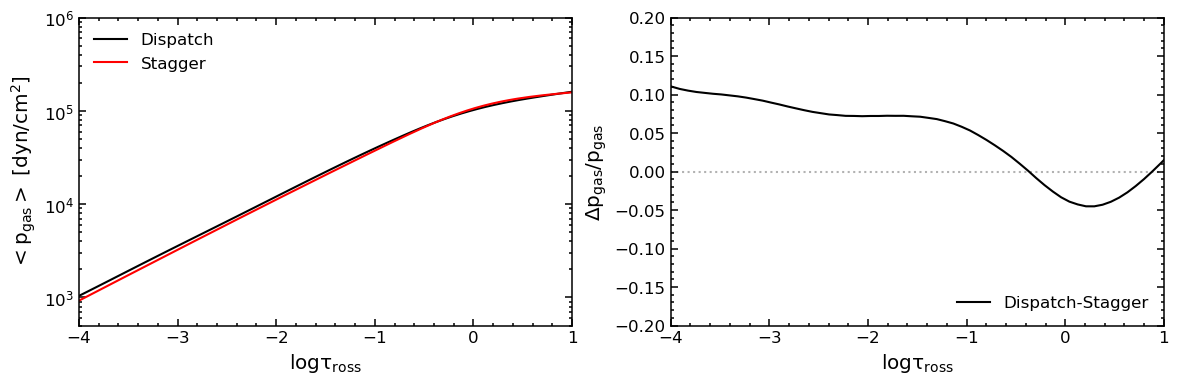

In [137]:
d_model   = MUST.plane_statistic(mean, model_τ, :Pg) 
d_stagger = MUST.plane_statistic(mean, stagger_τ, :Pg) 

z_model   = log.(10, MUST.axis(model_τ, :τ_ross, 3))
z_stagger = log.(10, MUST.axis(stagger_τ, :τ_ross, 3))
 
f, ax = plt.subplots(1, 2, figsize=(14,4))
basic_plot!.(ax)

mask = MUST.uniqueidx(z_stagger)
masks = sortperm(z_stagger[mask])
d_ip_stagger = LinearInterpolation(z_stagger[mask][masks], d_stagger[mask][masks])(z_model[2:end-1])

ax[1].set_xlim(-4, 1)
ax[2].set_xlim(-4, 1)
ax[1].set_ylim(5e2, 1e6)
ax[2].set_ylim(-0.2, 0.2)
ax[2].axhline(0, color="k", alpha=0.3, ls=":")

ax[1].semilogy(z_model, d_model, color="k", label="Dispatch")
ax[1].semilogy(z_stagger, d_stagger, color="r", label="Stagger")
ax[1].set_ylabel(L"\rm <p_{gas}>\ [dyn / cm^2]", fontsize="x-large")
ax[1].set_xlabel(L"\rm log \tau_{ross} ", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper left", fontsize="large");

ax[2].plot(z_model[2:end-1], (d_model[2:end-1] .- d_ip_stagger) ./ d_model[2:end-1], color="k", label="Dispatch-Stagger")
ax[2].set_ylabel(L"\rm \Delta p_{gas} / p_{gas}", fontsize="x-large")
ax[2].set_xlabel(L"\rm log \tau_{ross} ", fontsize="x-large")
ax[2].legend(framealpha=0, loc="lower right", fontsize="large")

f.savefig("disp_stag_pg_dpgpg_tauross_$(ext).pdf", bbox_inches="tight");

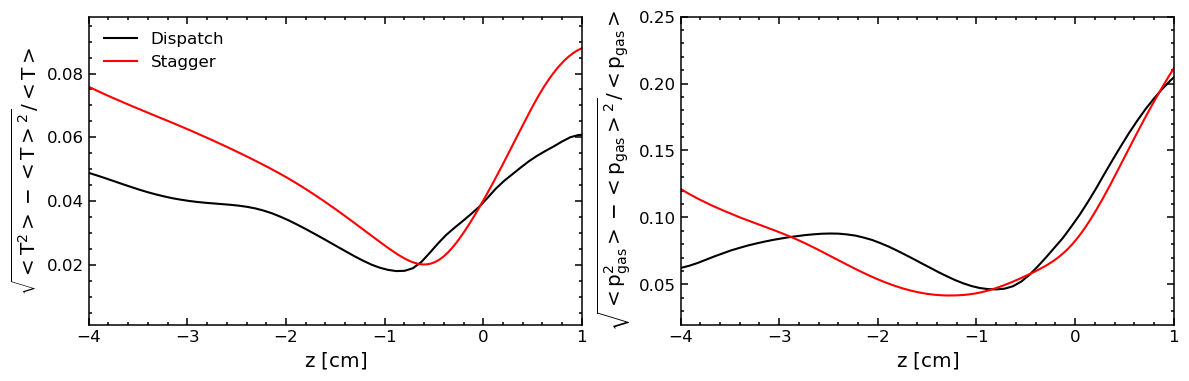

In [138]:
d_model     = MUST.plane_statistic(rms_fluctuation, model_τ, :T)
d_stagger   = MUST.plane_statistic(rms_fluctuation, stagger_τ, :T)
md_model    = MUST.plane_statistic(mean, model_τ, :T)
md_stagger  = MUST.plane_statistic(mean, stagger_τ, :T)
p_model     = MUST.plane_statistic(rms_fluctuation, model_τ, :pg)
p_stagger   = MUST.plane_statistic(rms_fluctuation, stagger_τ, :Pg)
mp_model    = MUST.plane_statistic(mean, model_τ, :pg)
mp_stagger  = MUST.plane_statistic(mean, stagger_τ, :Pg)

z_model   = log.(10, MUST.axis(model_τ, :τ_ross, 3))
z_stagger = log.(10, MUST.axis(stagger_τ, :τ_ross, 3))

f, ax = plt.subplots(1, 2, figsize=(14,4))
basic_plot!.(ax)

ax[1].set_xlim(-4, 1)
ax[2].set_xlim(-4, 1)
ax[2].set_ylim(0.02, 0.25)

ax[1].plot(z_model, d_model ./ md_model, color="k", label="Dispatch")
ax[1].plot(z_stagger, d_stagger ./ md_stagger, color="r", label="Stagger")
ax[1].set_ylabel(L"\rm \sqrt{<T^2> - <T>^2} / <T>", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper left", fontsize="large")

ax[2].plot(z_model, p_model ./ mp_model, color="k", label="Dispatch")
ax[2].plot(z_stagger, p_stagger ./ mp_stagger, color="r", label="Stagger")
ax[2].set_ylabel(L"\rm \sqrt{<p_{gas}^2> - <p_{gas}>^2} / <p_{gas}>", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

f.savefig("disp_stag_rmsT_rmsPg_tauross_$(ext).pdf", bbox_inches="tight");

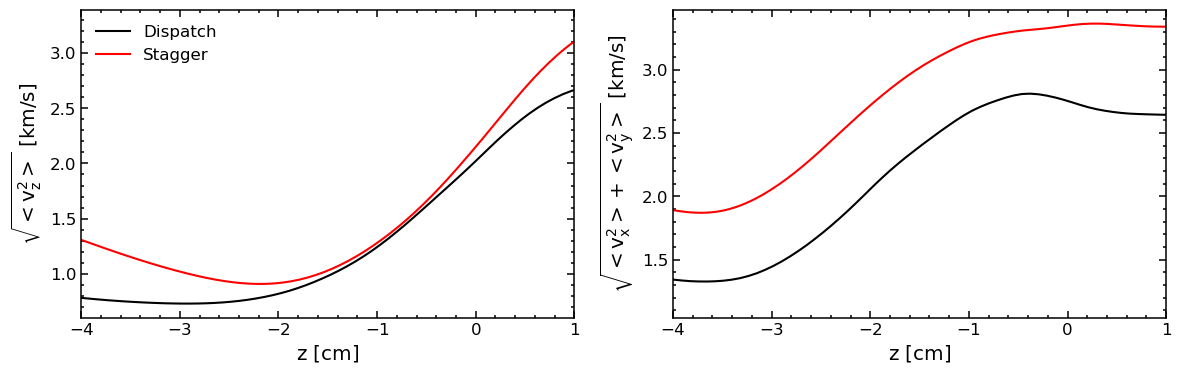

In [139]:
d_model     = MUST.plane_statistic(rms, model_τ, :uz) ./ 1e5
d_stagger   = MUST.plane_statistic(rms, stagger_τ, :uz) ./ 1e5

x_model     = MUST.plane_statistic(rms, model_τ, :ux) .^2
x_stagger   = MUST.plane_statistic(rms, stagger_τ, :ux) .^2
y_model     = MUST.plane_statistic(rms, model_τ, :uy) .^2
y_stagger   = MUST.plane_statistic(rms, stagger_τ, :uy) .^2

s_model = .√(x_model .+ y_model) ./ 1e5
s_stagger = .√(x_stagger .+ y_stagger) ./ 1e5

z_model   = log.(10, MUST.axis(model_τ, :τ_ross, 3))
z_stagger = log.(10, MUST.axis(stagger_τ, :τ_ross, 3))

f, ax = plt.subplots(1, 2, figsize=(14,4))
basic_plot!.(ax)

ax[1].set_xlim(-4, 1)
ax[2].set_xlim(-4, 1)

ax[1].plot(z_model, d_model, color="k", label="Dispatch")
ax[1].plot(z_stagger, d_stagger, color="r", label="Stagger")
ax[1].set_ylabel(L"\rm \sqrt{<v_z^2>} \ [km/s]", fontsize="x-large")
ax[1].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")
ax[1].legend(framealpha=0, loc="upper left", fontsize="large")

ax[2].plot(z_model, s_model, color="k", label="Dispatch")
ax[2].plot(z_stagger, s_stagger, color="r", label="Stagger")
ax[2].set_ylabel(L"\rm \sqrt{<v_x^2> + <v_y^2>} \ [km/s]", fontsize="x-large")
ax[2].set_xlabel(L"\rm z \ [cm]", fontsize="x-large")

f.savefig("disp_stag_rmsUz_rmsUxUy_tauross_$(ext).pdf", bbox_inches="tight");